#Connecting with Drive

In [1]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [2]:
project_path = '/content/MyDrive/MyDrive/training_mask_detection/'

#Importing Modules

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import pathlib

#Defining Hyperparamters

In [8]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

#Importing and Preparing the data

In [ ]:
imagePaths = list(paths.list_images('/content/MyDrive/MyDrive/training_mask_detection/dataset'))
print(imagePaths)
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    data.append(image)
    labels.append(label)
    
data = np.array(data, dtype="float32")
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

#Splitting the data and Augmenting the Features



In [5]:
(trainX, testX, trainY, testY) = train_test_split(data,
                                                  labels,
                                                  test_size=0.20,
                                                  stratify=labels,
                                                  random_state=42)
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

#Creating the model

In [6]:
baseModel = MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

9420800/9406464 [==============================] - 0s 0us/step


#Training the model

In [9]:
for layer in baseModel.layers:
	layer.trainable = False
    
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
34/34 [==============================] - 53s 1s/step - loss: 0.5418 - accuracy: 0.7697 - val_loss: 0.2304 - val_accuracy: 0.9891
Epoch 2/20
34/34 [==============================] - 48s 1s/step - loss: 0.2244 - accuracy: 0.9616 - val_loss: 0.1008 - val_accuracy: 0.9891
Epoch 3/20
34/34 [==============================] - 48s 1s/step - loss: 0.1212 - accuracy: 0.9785 - val_loss: 0.0600 - val_accuracy: 0.9891
Epoch 4/20
34/34 [==============================] - 48s 1s/step - loss: 0.0814 - accuracy: 0.9897 - val_loss: 0.0445 - val_accuracy: 0.9891
Epoch 5/20
34/34 [==============================] - 47s 1s/step - loss: 0.0638 - accuracy: 0.9897 - val_loss: 0.0355 - val_accuracy: 0.9891
Epoch 6/20
34/34 [==============================] - 48s 1s/step - loss: 0.0604 - accuracy: 0.9878 - val_loss: 0.0344 - val_accuracy: 0.9891
Epoch 7/20
34/34 [==============================] - 47s 1s/step - loss: 0.0499 - accuracy: 0.9897 - val_loss: 0.0290 - val_accuracy: 0.9891
Epoch 8/20
34/34 [==

#Showing Figure of the Training Loss and Accuracy

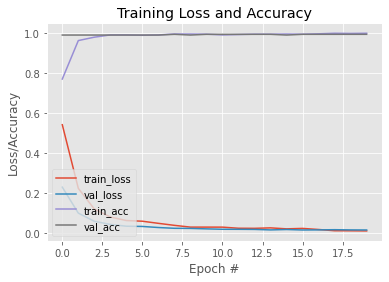

In [10]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

plt.show()

#Saving and Exporting The TensorFlow Lite model

In [11]:
export_dir = '/content/MyDrive/MyDrive/training_mask_detection/saved_model'
tf.saved_model.save(model, export_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('/content/MyDrive/MyDrive/training_mask_detection/model.tflite')
tflite_model_file.write_bytes(tflite_model)

INFO:tensorflow:Assets written to: /content/MyDrive/MyDrive/training_mask_detection/saved_model/assets


9516068